<a href="https://colab.research.google.com/github/trduc97/siamese_semantic_similarity/blob/main/Dissertation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This study goes into text mining using machine learning techniques, primarily focusing on deep learning. We aimed to accurately identify relevant pairing between presented document and search topics, a task with widespread application, via pairing Q&A directly, or coupled with a RAG system to improve responses quality from LLM, .... The project involved exploration and cleaning of the dataset, followed by tuning parameters and alternating different deep learning architeciture.

# Method
We began with an analysis of the dataset to determine the cleaning process and understand the distribution of the binary classes to determin the right metrics.

In data splitting, we used a 85% training, 10% validation, and 5% testing split, ensuring we can have optimal sample for our training process. Given the high level of complexity and high dimensionality of the data we are working with, most of the deep neural models are run on a P100 GPU

# Models

1. Deep Neural Networks (DNNs): We then experimented with various DNN configurations, adjusting layers count and nodes count, along with different activation functions. And find that aligned with current believe, gelu work particularly well for textual task.
We developed several complex CNN architectures, employing Siamese architecture with different neural layers

  - **Model 1**: traditional multi-layer Dense deep neural network with GLoVe embedding
  - **Model 2**: RNN + GloVe embedding
  - **Model 3**: GRU and Bidirectional GRU + GloVe embedding
  - **Model 4**: LSTM and Bidirectional LSTM + GloVe embedding
  - **Model 5**: LSTM + GloVe embedding + Siamese architecture (Paragraph<>Topic) + measure distance to determine similarity
  - **Model 5.1**: Testing with Manthantan/Euclidean/Cosine distance
  - **Model 6**: LSTM + BERT + Siamese architecture(Manhattan distance)

  Other potential tests:
    - **Model 7**: Using CNN in a Siamese architecture. While CNN is primarily applicable for images, it can also potentially find pattern in local pattern within the paragraph
    - **Model 8**: Using BSSM model architecture as suggest in "Bert-based Siamese Network for Semantic Similarity"
    https://iopscience.iop.org/article/10.1088/1742-6596/1684/1/012074/pdf





### 1. Data Setup

tensorflow and keras require consistency, and pandas may behave drastically different with different version so we need to specify here


In [3]:
# @title
!pip install keras==2.15.0
!pip install tensorflow==2.15.0
!pip install pandas==2.2.1
#!pip install nltk
#!pip install xgboost
#!pip install gensim
#!pip install bs4
#!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Libraries for text preprocessing
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

from scipy.sparse import hstack

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Libraries for vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder

# Libraries for ML
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score, f1_score,precision_recall_curve

import random
import warnings
warnings.simplefilter(action='ignore')

2024-06-27 00:34:21.182232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 00:34:21.182376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 00:34:21.317483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In order to ensure results reproducibility, we set the random seeds for numpy, tensorflow and the python random package to a constant value of 42. We then made use of the python pandas library to read the data into memory:

In [4]:
# @title
#Storing the output path of the .csv files to be downloaded
training_df, testing_df= '/kaggle/input/cs985-987-relevance-prediction-2024/relevance_train.parquet', '/kaggle/input/cs985-987-relevance-prediction-2024/relevance_test.parquet'

#Reading the .parquet files into a DataFrame
training_df, testing_df=pd.read_parquet(training_df), pd.read_parquet(testing_df)

training_df.head()

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
0,004c6120d0aa69da29cc045da0562168,0,Terrence McCoy,"<p>More than 60 years ago, a fair-skinned Iris...",By Terrence McCoy,Report on Irish baby homes documents use of in...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
1,005a1f0c2064487a7f15443b2a5f349a,0,Brian McNoldy,"<p>Hurricane Fred, which formed over the weeke...",By Brian McNoldy,Hurricane Fred is a fountain of ‘firsts’ in th...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
2,00722094-2935-11e2-b4e0-346287b7e56c,0,Editorial Board,"<p>EIGHT YEARS AGO this month, an inspiring mo...",By Editorial Board,Ukraine slides away from democracy,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
3,007d2856-7cc4-11e4-84d4-7c896b90abdc,0,Adam Bernstein,"<p>Mary Burke Washington, an economist who was...",By Adam Bernstein,"Mary Washington, government official and widow...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
4,009aafb6-0283-11e6-8bb1-f124a43f84dc,0,None,"<p>When Treasury Secretary Jack Lew <a href=""h...",None,Will women be shortchanged again?,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments


### 2. Exploratory Data Analysis

The basic format of the dataset we are working with including 2 main parts, the 'document' that we need to search through, (made up of columns 'title' and 'body'), and the 'topic' that we are interested in retrieving, (made up of columns 'description and 'narrative').   
We are working with an imbalance dataset, with only 1/9 documents are relevant to us

In [5]:
# @title
# Check target distribution
judgement_counts = training_df['judgement'].value_counts()
total = judgement_counts.sum()
percentages = (judgement_counts / total) * 100
print(percentages)

judgement
0    84.284847
1    15.715153
Name: count, dtype: float64


For relevance judgement, we consider the informative features about the article, and the user's query terms. Specifically we used the body and title features as representations of the article, and the topic_title and description features as representations of the user's query.

In [6]:
# @title
# visualization of the first 5 records
training_df.head()

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
0,004c6120d0aa69da29cc045da0562168,0,Terrence McCoy,"<p>More than 60 years ago, a fair-skinned Iris...",By Terrence McCoy,Report on Irish baby homes documents use of in...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
1,005a1f0c2064487a7f15443b2a5f349a,0,Brian McNoldy,"<p>Hurricane Fred, which formed over the weeke...",By Brian McNoldy,Hurricane Fred is a fountain of ‘firsts’ in th...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
2,00722094-2935-11e2-b4e0-346287b7e56c,0,Editorial Board,"<p>EIGHT YEARS AGO this month, an inspiring mo...",By Editorial Board,Ukraine slides away from democracy,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
3,007d2856-7cc4-11e4-84d4-7c896b90abdc,0,Adam Bernstein,"<p>Mary Burke Washington, an economist who was...",By Adam Bernstein,"Mary Washington, government official and widow...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
4,009aafb6-0283-11e6-8bb1-f124a43f84dc,0,None,"<p>When Treasury Secretary Jack Lew <a href=""h...",None,Will women be shortchanged again?,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments


In [7]:
# @title
# create a copy of the original dataset
training_df2 = training_df.copy()
# extract the useful representative features
training_df2 = training_df2.reindex(columns=['judgement','body','description','title','narrative'])

From the exploratory data analysis we can see that the training dataset has a imbalance dstribution for the two class of 'judgement'. The percentage of the '0' values is approximate 84.28% and the percentage for the '1' is around 15.71%. The 0 reflects the irrelevant pairing and 1 is relevant pairing.
The imbalance shows that most articles return are irrelevant to the queries. To consider the relevance judgement, we will use four key features. The 'body' and the 'title' is the actual content and title of the article. The 'description' and 'narative' is the details of the queries. To get the clearer picture we have shown the individual entries for the above important features. Finally we have created a copy of the dataset and reindexed the most important columns for assessing the article relevance.

# 2.Text preprocessing

In [8]:
# @title
# Check missing values
training_df2.isna().sum()

judgement       0
body           69
description     0
title           0
narrative       0
dtype: int64

In [9]:
# @title
# We will drop the articles with null body
training_df2.dropna(inplace=True) # intuitively, without knowing the body, it is almost impossible to find out if it is going to be a match
# Preprocessing function
def preprocess_text(text):
  #Removing links and tags
  soup=BeautifulSoup(text, 'html.parser')
  text=soup.get_text()
  text=text.lower()

  #Removing unncessary backslash
  text=re.sub(r'[^\w\s()/\\]', ' ',text)

  #Removing next line tags
  text=text.replace('\\n', '')

  #Removing unncessary 'xa0' string
  text=text.replace('\xa0', ' ')

  #Tokenizing
  tokens=word_tokenize(text)

  #Removing punctuation
  tokens=[word for word in tokens if word not in string.punctuation]

  #Removing stop-words
  stop_words=set(stopwords.words('english'))
  tokens=[word for word in tokens if word.lower() not in stop_words]

  #Lemantizing
  lemmatizer=WordNetLemmatizer()
  tokens=[lemmatizer.lemmatize(word) for word in tokens]
  sentence=' '.join(tokens)

  return sentence

Often the file from nltk does not automatically unzip after being download so we have a code to explicityly perform this base on the default path on kaggle and colab

In [10]:
# @title
import os
import zipfile

# Define the directories to try
directories_to_try = ["/root/nltk_data", "/usr/share/nltk_data"]

# Try each directory until successful
found = False
for directory in directories_to_try:
    try:
        # Check if the directory exists
        if os.path.exists(directory):
            # Define the path to the WordNet zip file
            wordnet_zip_path = os.path.join(directory, "corpora", "wordnet.zip")
            # Check if the WordNet zip file exists
            if os.path.exists(wordnet_zip_path):
                # Unzip WordNet data
                with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
                    zip_ref.extractall(os.path.join(directory, "corpora"))
                found = True
                break
    except Exception as e:
        print(f"Error: {e}")

if not found:
    print("WordNet data not found in either directory.")

In [12]:
testing_df.isna().sum()
testing_df.fillna('', inplace=True) # to retain the shape of the submission we choose to keep the empty values in the testing

In [13]:
# @title
# columns to clean in training
columns_to_clean = ["title", "body","description","narrative" ]

# applying cleaning function to each column
training_df2 = training_df2[columns_to_clean].map(preprocess_text)
testing_df = testing_df[columns_to_clean].map(preprocess_text)

# we re-attached the judgement column back to training_df2
training_df2['judgement'] = training_df['judgement']

In [14]:
# @title
print(training_df2['body'][0])
print(training_df2['description'][0])
print(training_df2['title'][0])
print(training_df2['narrative'][0])

60 year ago fair skinned irish politician named sally mulready born home unwed mother called st patrick sat road named navan dublin mulready one four sibling born brother john never made st pat like hundred baby born irish home fallen woman john died 1947 two month old inanition death record read according rte news failure thrive rte news said record carried mystery john reason buried 1950 three year death oddity first discarded clerical error john record designation anatomical study infant remains fact given researcher trinity college dublin used medical research though unclear whether mother given consent mulready eventually tracked burial plot explained irish time found marked stick number imagine happening child young baby died well family family influence happen baby beside john according recent irish government report confirming augmenting earlier report rte investigation called anatomy scandal report preliminary review designed set framework full formal investigation ordered iri

In [15]:
# @title
def grouping_col(data):
  data['document'] = data['title'] + ' ' + data['body']
  data['topic'] = data['description'] + ' ' + data['narrative']
  data['concatenated_text'] = data['document'] + '[SEP]' + data['topic'] # [SEP] are default denominator for splitting text, will be relevant when apply on BERT
  return data

training_df2 = grouping_col(training_df2)
testing_df = grouping_col(testing_df)
df_combine = training_df2.copy()

In [19]:
training_df2.to_csv('cleaned_training_df2.csv',index=False)

In [20]:
training_df2.to_parquet('cleaned_training_df2.parquet.gzip',
              compression='gzip')  
training_df2 = pd.read_parquet('/kaggle/working/cleaned_training_df2.parquet.gzip')  

,title,body,description,narrative,judgement,document,topic,concatenated_text
0,report irish baby home document use infant med...,60 year ago fair skinned irish politician name...,pertinent document reflect fact woman continue...,pertinent document relating issue discus lack ...,0,report irish baby home document use infant med...,pertinent document reflect fact woman continue...,report irish baby home document use infant med...
1,hurricane fred fountain first atlantic ocean,hurricane fred formed weekend far eastern atla...,pertinent document reflect fact woman continue...,pertinent document relating issue discus lack ...,0,hurricane fred fountain first atlantic ocean h...,pertinent document reflect fact woman continue...,hurricane fred fountain first atlantic ocean h...
2,ukraine slide away democracy,eight year ago month inspiring movement took h...,pertinent document reflect fact woman continue...,pertinent document relating issue discus lack ...,0,ukraine slide away democracy eight year ago mo...,pertinent document reflect fact woman continue...,ukraine slide away democracy eight year ago mo...
3,mary washington government official widow form...,mary burke washington economist ranking offici...,pertinent document reflect fact woman continue...,pertinent document relating issue discus lack ...,0,mary washington government official widow form...,pertinent document reflect fact woman continue...,mary washington government official widow form...
4,woman shortchanged,treasury secretary jack lew announced last jun...,pertinent document reflect fact woman continue...,pertinent document relating issue discus lack ...,0,woman shortchanged treasury secretary jack lew...,pertinent document reflect fact woman continue...,woman shortchanged treasury secretary jack lew...
...,...,...,...,...,...,...,...,...
26227,daily 202 liberal hypocrisy abounds electoral ...,breanne deppischthe big idea ti season hypocri...,diversion u corn crop ethanol fuel increase fo...,identify document discus impact growing corn i...,0,daily 202 liberal hypocrisy abounds electoral ...,diversion u corn crop ethanol fuel increase fo...,daily 202 liberal hypocrisy abounds electoral ...
26228,transportation dept get strict rule train carr...,almost two year runaway tank car train erupted...,diversion u corn crop ethanol fuel increase fo...,identify document discus impact growing corn i...,0,transportation dept get strict rule train carr...,diversion u corn crop ethanol fuel increase fo...,transportation dept get strict rule train carr...
26229,joni ernst iowa campaign make quick work war w...,urbandale iowathe machine shed restaurant wait...,diversion u corn crop ethanol fuel increase fo...,identify document discus impact growing corn i...,0,joni ernst iowa campaign make quick work war w...,diversion u corn crop ethanol fuel increase fo...,joni ernst iowa campaign make quick work war w...
26230,real reason american love bacon breakfast,secret history bacon almost nobody know tell n...,diversion u corn crop ethanol fuel increase fo...,identify document discus impact growing corn i...,0,real reason american love bacon breakfast secr...,diversion u corn crop ethanol fuel increase fo...,real reason american love bacon breakfast secr...


In [106]:
training_df2 = pd.read_csv('/kaggle/input/clean-data/clean_train_data.csv')  

# 3.Neural Network with GloVe embedding

In general, the problem of matching a whole document with a provided topics can be attritube to the broader topics of textual similarity, or sentence similarity, so below we will explore severall approach that incorporated ideas within representation models, interaction models and pre-trained models.

## 3.1. Importing libraries

In [7]:
# @title
import pickle
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import GlobalMaxPool2D, GlobalAvgPool2D, Multiply, Subtract, Add, Activation, MaxPool2D, Concatenate,Reshape, Conv2D, MaxPooling2D, Dropout, Input, Embedding, Bidirectional, LSTM, Dense, Lambda, GlobalAveragePooling1D, Reshape, GRU, Flatten, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.activations import gelu
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import zipfile
import os
# Checking for GPU
len(tf.config.list_physical_devices('GPU'))

# Setting epoch_count = 1 just to let the file run as demo, we have saved the trained models in a separated folder and will be using this to review
batch_size=256
epoch_count=45
activation_func=gelu

In this part, along with the typical singple input model, we will also be consider a **Siamese** model architecture, with 2 separate inputs, each for 'topic' and 'document' that will be later merge into 1 binary output layer downstream. With these approach so we will have in total 3 different set of features, one each for 'document' and 'topic', and one for 'concatenatex_text', which is the combination of the first 2.

In [107]:
# @title
X,y = training_df2[['document','topic','concatenated_text']],training_df2['judgement']
# We are using a train/validate/test ratio of 0.85/0.1/0.05
# Split data into train and tempt (combined of validate and test)
X_train,X_temp,y_train,y_temp = train_test_split(X, y, test_size=0.15, random_state=42)

# Split tempt to validate and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

X_train_doc,X_train_topic = X_train['document'].values, X_train['topic'].values
X_val_doc,X_val_topic = X_val['document'].values, X_val['topic'].values
X_test_doc,X_test_topic = X_test['document'].values, X_test['topic'].values

X_train_concat = X_train['concatenated_text'].values
X_val_concat = X_val['concatenated_text'].values
X_test_concat = X_test['concatenated_text'].values

As stated above, since we are looking to find the matching document with the provided topic, se while the 'judgement' are binary, we are mostly interest in the minority class, or y = 1, indicating that the document is relevant to the provided topics. Because of the imbalancy, so accuracy can be a misleading metrics, while taking into account multiple metrics like accuracy, precision, recall at once can make poor comparison, so we will mainly base our calculation on F1-Score. Due to tensorflow does not include f1 score as metrics, so we have to defined our own incorporating into tensorflow backend

## 3.2. Generating word Embedding using GloVe
There are different option for pre-trained dataset but we choose GloVe 6B, with the 300 dimension variant, as it was based on Wikipedia 2014 anđ Gigaword5, which are intuitively related to the vocabulary of the text we are processing, also because it's relatively light weight to incorporate into our models. We hope that using GloVe will provide our model with global semantic representation and generalization, based on the dataset it was trained on.

In [9]:
# @title
# Load GloVe embeddings
def load_glove_embeddings(embedding_path):
    embedding_index = {}
    with open(embedding_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    return embedding_index

embedding_dim = 300

# Load GloVe embeddings
glove_path = '/kaggle/input/glove-6b/glove.6B.'+ str(embedding_dim) +'d.txt'
glove_embeddings_index = load_glove_embeddings(glove_path)

# Custom function to map words to GloVe embeddings
def map_word_to_glove(word):
    return glove_embeddings_index.get(word, np.zeros(embedding_dim)) # 300 is the dimensionality of GloVe embeddings

# Define a function to convert text to embeddings using the vectorizer and custom mapping
def text_to_embedding(text):
    words = tf.strings.split(text)
    embeddings = tf.map_fn(lambda word: tf.py_function(map_word_to_glove, [word], Tout=tf.float32), words)
    return embeddings

In [11]:
# @title
doc_max_sequence_length = 500
doc_max_tokens = 5000

topic_max_sequence_length = 500
topic_max_tokens = 500

concat_max_sequence_length = 1000
concat_max_tokens = 6000

# Create a TextVectorization layer with custom standardization and mapping function
topic_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=topic_max_tokens,
    output_mode='int',
    output_sequence_length=topic_max_sequence_length,
    standardize=None,  # Disable standardization

)
topic_vectorizer.adapt(X_train['topic'])

# Create a TextVectorization layer with custom standardization and mapping function
doc_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=doc_max_tokens,
    output_mode='int',
    output_sequence_length=doc_max_sequence_length,
    standardize=None,  # Disable standardization
)
doc_vectorizer.adapt(X_train['document'])

# Create a TextVectorization layer with custom standardization and mapping function
concat_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=concat_max_tokens,
    output_mode='int',
    output_sequence_length=concat_max_sequence_length,
    standardize=None,  # Disable standardization

)
concat_vectorizer.adapt(X_train['concatenated_text'])

In [12]:
# @title
# Get the vocabulary from the topic_vectorizer
topic_vocab = topic_vectorizer.get_vocabulary()
doc_vocab = doc_vectorizer.get_vocabulary()
concat_vocab = concat_vectorizer.get_vocabulary()

# Initialize an empty list to store the embeddings
topic_embedding = []
doc_embedding = []
concat_embedding = []
# Iterate through the vocabulary and map each word to its GloVe embedding
for word in topic_vocab:
    topic_embedding.append(map_word_to_glove(word))

for word in doc_vocab:
    doc_embedding.append(map_word_to_glove(word))

for word in concat_vocab:
    concat_embedding.append(map_word_to_glove(word))


# Convert the list of embedding vectors to a numpy array
topic_embedding = np.array(topic_embedding)
doc_embedding = np.array(doc_embedding)
concat_embedding = np.array(concat_embedding)

# Check the shape of the embedding matrix
print("Shape of topic embedding:", topic_embedding.shape)
print("Shape of document embedding:", doc_embedding.shape)
print("Shape of concatened text embedding:", concat_embedding.shape)

Shape of topic embedding: (500, 300)
Shape of document embedding: (5000, 300)
Shape of concatened text embedding: (6000, 300)


## 3.3.Deep NN with GloVe Embedding

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import os
import zipfile

class ModelTraining:
    def __init__(self, y_train):
        # Prepare a dictionary to record result
        self.dl_results={}
        # Rebalanced classes weights
        self.class_weights = self.compute_class_weights(y_train)
        # Define metrics
        self.metrics = self.define_metrics()
        self._optimizer='adam'
        self._loss_func='binary_crossentropy'
        self._monitor='val_loss'
        self.histories={}
        # callback functions
        self.callbacks = self.setup_callbacks()


    # Setting up f1_score function for use during training process
    def f1_score_metrics(self, y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def define_metrics(self):
        return [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#            tf.keras.metrics.Precision(name='precision'),
#            tf.keras.metrics.Recall(name='recall'),
#            tf.keras.metrics.AUC(name='auc'),
            self.f1_score_metrics,
        ]
    #Calculate class weights
    def compute_class_weights(self, y_train):
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                          classes=np.unique(y_train),
                                                          y=y_train)
        # Convert class weights to a dictionary
        return dict(enumerate(class_weights))

    def setup_callbacks(self):
        lrd = ReduceLROnPlateau(monitor=self._monitor,
                                patience=5,  # reduce lr every 5 epochs with no improvement
                                verbose=1,
                                factor=0.7,  # reduction factor
                                min_lr=1e-4)  # minimum lr
        mcp = ModelCheckpoint('model.h5.keras',
                              monitor=self._monitor,
                              verbose=1,
                              save_best_only=True,  # Save 1 optimal model
                              mode='min')  # Since we are looking to minimize loss
        es = EarlyStopping(monitor=self._monitor, verbose=1,
                           patience=15,  # early stop after 15 consecutive epochs with no improvement
                           mode='min',  # Since we are looking to minimize loss
                           restore_best_weights=True)  # Revert back to version with best loss
        return [lrd, mcp, es]

    # Setting up function to measure the models performance
    def dl_metrics(self, test_pred, test_label, model_name, threshold=0.5):
        binary_test_pred = (test_pred > threshold).astype(int)
        report = classification_report(test_label, binary_test_pred)
        print(report)
        accuracy = accuracy_score(test_label, binary_test_pred)
        precision = precision_score(test_label, binary_test_pred)
        recall = recall_score(test_label, binary_test_pred)
        f1 = f1_score(test_label, binary_test_pred)
        pred_count = sum(binary_test_pred)
        print('Total predictions: ', pred_count)
        self.dl_results[model_name] = [accuracy, precision, recall, f1, pred_count]

    # Code to zip
    def zip_folder(self, folder_path, zip_path):
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Walk through all the files in the folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    # Add each file to the zip file
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, folder_path))
    def compile_model(self,model, model_name):
        model.compile(optimizer=self._optimizer,
                      loss=self._loss_func,
                      metrics=self.metrics)
        model.summary()
        model_plot = model_name +'.png'
        plot_model(model,show_shapes=True,to_file = model_plot)
    # Code to train model
    def train_model(self, model,model_name,
                    x_train, y_train,
                    x_val, y_val,
                    x_test, y_test,
                    epochs=epoch_count, batch_size=batch_size):

        history = model.fit(x_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(x_val, y_val),
                            class_weight=self.class_weights,
                            #callbacks=self.callbacks
                            )
        self.histories[model_name] = history

        # make a prediction and save result
        test_pred = model.predict(x_test)

        self.dl_metrics(test_pred.flatten(),y_test, model_name)
        # Saving the trained model
        model.save(model_name)

        # Specify the folder to be zipped and the path to save the zip file
        zip_file_path = model_name + '.zip'

        # Call the function to zip the folder
        self.zip_folder(model_name, zip_file_path)

### 3.3.1. Dense NN with just embedding layer

In [14]:
neural='dense'
embedding=''
architecture=''
model_name=neural+'_'+embedding+'_'+architecture
print(model_name)

dense__


In [15]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='concat_input')

# Use the tokenizer for each types
concat_tokens = concat_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                    output_dim=embedding_dim,
                                                    #input_length=concat_max_sequence_length,
                                                   mask_zero=True)(concat_tokens)

# Flatten the input if needed
flattened_input = tf.keras.layers.Flatten()(concat_embedding_layer)

# Define dense layers with L2 regularization
dense1 = Dense(50, activation=activation_func, kernel_regularizer=regularizers.l2(0.01))(flattened_input)
dropout1 = Dropout(0.5)(dense1)  # Add dropout
dense2 = Dense(50, activation=activation_func, kernel_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(dense2)  # Add dropout
dense3 = Dense(50, activation=activation_func, kernel_regularizer=regularizers.l2(0.01))(dropout2)


# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dense3)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

In [16]:
model_training = ModelTraining(y_train)
model_training.compile_model(model, model_name)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 1000, 300)         1800000   
                                                                 
 flatten (Flatten)           (None, 300000)            0         
                                                                 
 dense (Dense)               (None, 50)                15000050  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                             

In [17]:
model_training.train_model(model, model_name,
                           X_train_concat, y_train,
                           X_val_concat, y_val,
                           X_test_concat, y_test,
                           )

Epoch 1/45


I0000 00:00:1719448601.544578     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - 20s 210ms/step - loss: 1.6225 - accuracy: 0.5639 - f1_score_metrics: 0.2386 - val_loss: 1.2502 - val_accuracy: 0.8277 - val_f1_score_metrics: 0.1241
Epoch 2/45
66/66 [==============================] - 6s 96ms/step - loss: 1.1133 - accuracy: 0.6433 - f1_score_metrics: 0.3358 - val_loss: 1.1384 - val_accuracy: 0.5695 - val_f1_score_metrics: 0.3823
Epoch 3/45
66/66 [==============================] - 6s 91ms/step - loss: 1.0670 - accuracy: 0.7905 - f1_score_metrics: 0.5090 - val_loss: 0.9971 - val_accuracy: 0.8489 - val_f1_score_metrics: 0.5237
Epoch 4/45
66/66 [==============================] - 5s 72ms/step - loss: 1.1294 - accuracy: 0.8497 - f1_score_metrics: 0.6254 - val_loss: 1.2421 - val_accuracy: 0.7898 - val_f1_score_metrics: 0.5086
Epoch 5/45
66/66 [==============================] - 5s 70ms/step - loss: 1.1250 - accuracy: 0.8887 - f1_score_metrics: 0.7075 - val_loss: 1.2440 - val_accuracy: 0.8514 - val_f1_score_metrics: 0.5457
Epoch 6/45
66/

### 3.3.2. Dense NN with GloVe
The main goal of this experimentation is to see if the Embedding will improve the training result - The results during the process indicate a slight imporvement interm of F1-score but only by around 2%

In [18]:
neural='dense'
embedding='GloVe'
architecture=''
model_name=neural+'_'+embedding+'_'+architecture
print(model_name)

dense_GloVe_


In [19]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='concat_input')

# Use the tokenizer for each types
concat_tokens = concat_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                      output_dim=embedding_dim,
                                                     weights=[concat_embedding],
                                                      #input_length=concat_max_sequence_length,
                                                      trainable=True, mask_zero=True)(concat_tokens)

# Flatten the input if needed
flattened_input = tf.keras.layers.Flatten()(concat_embedding_layer)

# Define dense layers with L2 regularization
dense1 = Dense(50, activation=activation_func, kernel_regularizer=regularizers.l2(0.01))(flattened_input)
dropout1 = Dropout(0.5)(dense1)  # Add dropout
dense2 = Dense(50, activation=activation_func, kernel_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(dense2)  # Add dropout
dense3 = Dense(50, activation=activation_func, kernel_regularizer=regularizers.l2(0.01))(dropout2)

# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dense3)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

In [20]:
model_training.compile_model(model, model_name)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 1000, 300)         1800000   
                                                                 
 flatten_1 (Flatten)         (None, 300000)            0         
                                                                 
 dense_4 (Dense)             (None, 50)                15000050  
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                           

In [21]:
model_training.train_model(model, model_name,
                           X_train_concat, y_train,
                           X_val_concat, y_val,
                           X_test_concat, y_test,
                           )

Epoch 1/45
66/66 [==============================] - 10s 121ms/step - loss: 2.3257 - accuracy: 0.6301 - f1_score_metrics: 0.2331 - val_loss: 1.5118 - val_accuracy: 0.4053 - val_f1_score_metrics: 0.2846
Epoch 2/45
66/66 [==============================] - 5s 76ms/step - loss: 1.3030 - accuracy: 0.7435 - f1_score_metrics: 0.2874 - val_loss: 1.1695 - val_accuracy: 0.8388 - val_f1_score_metrics: 0.2641
Epoch 3/45
66/66 [==============================] - 4s 67ms/step - loss: 1.2083 - accuracy: 0.7727 - f1_score_metrics: 0.3417 - val_loss: 1.1687 - val_accuracy: 0.5973 - val_f1_score_metrics: 0.3401
Epoch 4/45
66/66 [==============================] - 4s 65ms/step - loss: 1.0815 - accuracy: 0.7911 - f1_score_metrics: 0.3977 - val_loss: 1.0561 - val_accuracy: 0.8130 - val_f1_score_metrics: 0.4388
Epoch 5/45
66/66 [==============================] - 4s 59ms/step - loss: 1.1436 - accuracy: 0.7992 - f1_score_metrics: 0.4542 - val_loss: 1.2041 - val_accuracy: 0.8231 - val_f1_score_metrics: 0.4562
Epo

## 3.4. RNN with GLoVe

In [22]:
neural='rnn'
embedding='glove'
architecture=''
model_name=neural+'_'+embedding+'_'+architecture
print(model_name)

rnn_glove_


## 3.5. GRU and BiGRU with GLoVe

### 3.5.1. GRU with GloVe

In [23]:
neural='gru'
embedding='glove'
architecture=''
model_name=neural+'_'+embedding+'_'+architecture
print(model_name)

gru_glove_


### 3.5.2. BiGRU with GloVe

In [24]:
neural='bigru'
embedding='glove'
architecture=''
model_name=neural+'_'+embedding+'_'+architecture
print(model_name)

bigru_glove_


## 3.6. LSTM and BiLSTM with GLoVe
As LSTM are mainly for sequential data such as text so we are experimenting to see if there is a clear improvement with just LSTM - though since we are looking for textual similarity, which might be outside of sequential pattern.

### 3.6.1. LSTM

In [25]:
neural='LSTM'
embedding='GloVe'
architecture=''
model_name=neural+'_'+embedding+'_'+architecture
print(model_name)

LSTM_GloVe_


In [26]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                      dtype=tf.string, name='concat_input')

# Use the tokenizer for each type
concat_tokens = concat_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                   output_dim=embedding_dim,
                                                   weights=[concat_embedding],
                                                   #input_length=concat_max_sequence_length,
                                                   trainable=True, mask_zero=True)(concat_tokens)

# LSTM layers with dropout and regularizers
lstm1 = LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(concat_embedding_layer)
dropout1 = Dropout(0.5)(lstm1)  # Add dropout
lstm2 = LSTM(50, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(lstm2)  # Add dropout

# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout2)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

In [27]:
model_training.compile_model(model, model_name)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 1000, 300)         1800000   
                                                                 
 lstm (LSTM)                 (None, 1000, 50)          70200     
                                                                 
 dropout_4 (Dropout)         (None, 1000, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                           

In [28]:
model_training.train_model(model, model_name,
                           X_train_concat, y_train,
                           X_val_concat, y_val,
                           X_test_concat, y_test,
                           )

Epoch 1/45
66/66 [==============================] - 27s 267ms/step - loss: 2.7479 - accuracy: 0.6413 - f1_score_metrics: 0.3314 - val_loss: 1.4378 - val_accuracy: 0.5690 - val_f1_score_metrics: 0.3469
Epoch 2/45
66/66 [==============================] - 13s 194ms/step - loss: 1.0085 - accuracy: 0.6421 - f1_score_metrics: 0.3775 - val_loss: 0.7682 - val_accuracy: 0.6640 - val_f1_score_metrics: 0.3696
Epoch 3/45
66/66 [==============================] - 11s 168ms/step - loss: 0.7085 - accuracy: 0.6507 - f1_score_metrics: 0.3863 - val_loss: 0.7312 - val_accuracy: 0.5862 - val_f1_score_metrics: 0.3632
Epoch 4/45
66/66 [==============================] - 11s 170ms/step - loss: 0.6447 - accuracy: 0.6397 - f1_score_metrics: 0.3896 - val_loss: 0.6162 - val_accuracy: 0.6549 - val_f1_score_metrics: 0.3733
Epoch 5/45
66/66 [==============================] - 11s 171ms/step - loss: 0.6227 - accuracy: 0.6576 - f1_score_metrics: 0.3991 - val_loss: 0.6460 - val_accuracy: 0.6059 - val_f1_score_metrics: 0.

### 3.6.2. Bidirectional LSTM

In [29]:
# @title
# Define input layers for 'document' and 'topic'
concat_input = tf.keras.layers.Input(shape=(1,),
                                      dtype=tf.string, name='concat_input')

# Use the tokenizer for each type
concat_tokens = concat_vectorizer(concat_input)

# Embedding layer for 'document'
concat_embedding_layer = tf.keras.layers.Embedding(input_dim=len(concat_vocab),
                                                   output_dim=embedding_dim,
                                                   weights=[concat_embedding],
                                                   trainable=True,
                                                   mask_zero=True)(concat_tokens)

# LSTM layers with dropout and regularizers
lstm1 =  Bidirectional(LSTM(50, return_sequences=True,
                            kernel_regularizer=regularizers.l2(0.01),
                            recurrent_regularizer=regularizers.l2(0.01)))(concat_embedding_layer)
dropout1 = Dropout(0.5)(lstm1)  # Add dropout
lstm2 =  Bidirectional(LSTM(50, kernel_regularizer=regularizers.l2(0.01),
                            recurrent_regularizer=regularizers.l2(0.01)))(dropout1)
dropout2 = Dropout(0.5)(lstm2)  # Add dropout

# Output layer for binary classification (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout2)

# Define the model
model = tf.keras.Model(inputs=concat_input, outputs=output_layer)

In [30]:
model_training.compile_model(model, model_name)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concat_input (InputLayer)   [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 1000, 300)         1800000   
                                                                 
 bidirectional (Bidirection  (None, 1000, 100)         140400    
 al)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1000, 100)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               6040

In [31]:
model_training.train_model(model, model_name,
                           X_train_concat, y_train,
                           X_val_concat, y_val,
                           X_test_concat, y_test
                           )

Epoch 1/45
66/66 [==============================] - 47s 449ms/step - loss: 5.3073 - accuracy: 0.6490 - f1_score_metrics: 0.3382 - val_loss: 2.2353 - val_accuracy: 0.6842 - val_f1_score_metrics: 0.3826
Epoch 2/45
66/66 [==============================] - 23s 345ms/step - loss: 1.3570 - accuracy: 0.7067 - f1_score_metrics: 0.4369 - val_loss: 0.8866 - val_accuracy: 0.7054 - val_f1_score_metrics: 0.4466
Epoch 3/45
66/66 [==============================] - 22s 331ms/step - loss: 0.6502 - accuracy: 0.7851 - f1_score_metrics: 0.5369 - val_loss: 0.5941 - val_accuracy: 0.7756 - val_f1_score_metrics: 0.4936
Epoch 4/45
66/66 [==============================] - 21s 324ms/step - loss: 0.4807 - accuracy: 0.8229 - f1_score_metrics: 0.6004 - val_loss: 0.4951 - val_accuracy: 0.8176 - val_f1_score_metrics: 0.5223
Epoch 5/45
66/66 [==============================] - 21s 322ms/step - loss: 0.4095 - accuracy: 0.8509 - f1_score_metrics: 0.6510 - val_loss: 0.5452 - val_accuracy: 0.7792 - val_f1_score_metrics: 0.

## 3.7. Siamese Neural Network with GloVe embedding
This is just a separate test to see if the Siamese architecture by itself help imporve performance


### 3.7.1. Siamese LSTM with cosine distance

In [55]:
neural='lstm'
embedding='glove'
architecture='siamese'
distance='cosine'
model_name=neural+'_'+embedding+'_'+architecture+'_'+distance
print(model_name)

lstm_glove_siamese_cosine


In [56]:
# @title
def auroc(y_true, y_pred):
    auc = tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)
    return auc
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)
# Define input layers for 'document' and 'topic'
document_input = tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.string, name='document_input')
topic_input = tf.keras.layers.Input(shape=(1,),
                                    dtype=tf.string, name='topic_input')

# Use the tokenizer for each types
document_tokens = doc_vectorizer(document_input)

topic_tokens = topic_vectorizer(topic_input)

# Embedding layer for 'document'
document_embedding_layer = tf.keras.layers.Embedding(input_dim=len(doc_vocab),
                                                      output_dim=embedding_dim,
                                                     weights=[doc_embedding],
                                                      #input_length=doc_max_sequence_length,
                                                      trainable=True, mask_zero=True)(document_tokens)

# Embedding layer for 'topic'
topic_embedding_layer = tf.keras.layers.Embedding(input_dim=len(topic_vocab),
                                                  output_dim=embedding_dim,
                                                  weights=[topic_embedding],
                                                  #input_length=topic_max_sequence_length,
                                                  trainable=True, mask_zero=True)(topic_tokens)
lstm_1 = document_embedding_layer
lstm_2 = topic_embedding_layer


common_lstm = LSTM(64,return_sequences=True, activation="relu")
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])

    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([document_input, topic_input], out)

In [57]:
model_training.compile_model(model, model_name)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['document_input[0][0]']      
 Vectorization)                                                                                   
                                                                                            

In [58]:

model_training.train_model(model, model_name,
                           [X_train_doc,X_train_topic], y_train,
                           [X_val_doc, X_val_topic], y_val,
                           [X_test_doc, X_test_topic], y_test,
                           epochs=15)


Epoch 1/15
66/66 [==============================] - 116s 2s/step - loss: 0.6436 - accuracy: 0.7249 - f1_score_metrics: 0.3710 - val_loss: 0.5885 - val_accuracy: 0.6700 - val_f1_score_metrics: 0.3982
Epoch 2/15
66/66 [==============================] - 107s 2s/step - loss: 0.5053 - accuracy: 0.7585 - f1_score_metrics: 0.4953 - val_loss: 0.5185 - val_accuracy: 0.7196 - val_f1_score_metrics: 0.4539
Epoch 3/15
66/66 [==============================] - 106s 2s/step - loss: 0.3709 - accuracy: 0.8327 - f1_score_metrics: 0.6167 - val_loss: 0.4271 - val_accuracy: 0.7948 - val_f1_score_metrics: 0.4908
Epoch 4/15
66/66 [==============================] - 106s 2s/step - loss: 0.2466 - accuracy: 0.8999 - f1_score_metrics: 0.7435 - val_loss: 0.4611 - val_accuracy: 0.8242 - val_f1_score_metrics: 0.4935
Epoch 5/15
66/66 [==============================] - 105s 2s/step - loss: 0.1485 - accuracy: 0.9456 - f1_score_metrics: 0.8437 - val_loss: 0.5436 - val_accuracy: 0.8272 - val_f1_score_metrics: 0.4937
Epoch

### 3.7.2 Siamese Bidirectional LSTM with euclidean distance

In [49]:
neural='bilstm'
embedding='glove'
architecture='siamese'
distance='euclidean'
model_name=neural+'_'+embedding+'_'+architecture+'_'+distance
print(model_name)

bilstm_glove_siamese_euclidean


In [50]:
# @title
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


# Define input layers for 'document' and 'topic'
document_input = Input(shape=(1,), dtype=tf.string, name='document_input')
topic_input = Input(shape=(1,), dtype=tf.string, name='topic_input')

# Use the tokenizer for each type
document_tokens = doc_vectorizer(document_input)
topic_tokens = topic_vectorizer(topic_input)

# Embedding layer for 'document'
document_embedding_layer = tf.keras.layers.Embedding(input_dim=len(doc_vocab),
                                                      output_dim=embedding_dim,
                                                     weights=[doc_embedding],
                                                      #input_length=doc_max_sequence_length,
                                                      trainable=True, mask_zero=True)(document_tokens)

# Embedding layer for 'topic'
topic_embedding_layer = tf.keras.layers.Embedding(input_dim=len(topic_vocab),
                                                  output_dim=embedding_dim,
                                                  weights=[topic_embedding],
                                                  #input_length=topic_max_sequence_length,
                                                  trainable=True, mask_zero=True)(topic_tokens)

distance = Lambda(euclidean_distance)([document_embedding_layer, topic_embedding_layer])

# Bidirectional LSTM layers for 'document' and 'topic'
bidirectional_lstm_document = Bidirectional(LSTM(units=256, activation=activation_func, return_sequences=True, dropout=0.5))(distance)
bidirectional_lstm_topic = Bidirectional(LSTM(units=256, activation=activation_func, return_sequences=True, dropout=0.5))(distance)

# Dense layer
dense_combined = Dense(units=32, activation=activation_func)(bidirectional_lstm_document)


# Dense layer
output = Dense(units=1, activation='sigmoid')(dense_combined)

# Define the model
model = Model(inputs=[document_input, topic_input], outputs=output)

In [51]:
model_training.compile_model(model, model_name)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['document_input[0][0]']      
 Vectorization)                                                                                   
                                                                                            

In [52]:
model_training.train_model(model, model_name,
                           [X_train_doc,X_train_topic], y_train,
                           [X_val_doc, X_val_topic], y_val,
                           [X_test_doc, X_test_topic], y_test,
                           )

Epoch 1/45
66/66 [==============================] - 14s 132ms/step - loss: 0.7421 - accuracy: 0.5714 - f1_score_metrics: 0.2357 - val_loss: 0.6771 - val_accuracy: 0.8332 - val_f1_score_metrics: 0.1226
Epoch 2/45
66/66 [==============================] - 5s 79ms/step - loss: 0.6938 - accuracy: 0.4307 - f1_score_metrics: 0.2570 - val_loss: 0.7126 - val_accuracy: 0.1789 - val_f1_score_metrics: 0.2690
Epoch 3/45
66/66 [==============================] - 5s 81ms/step - loss: 0.6932 - accuracy: 0.3506 - f1_score_metrics: 0.2660 - val_loss: 0.7325 - val_accuracy: 0.1774 - val_f1_score_metrics: 0.2687
Epoch 4/45
66/66 [==============================] - 4s 60ms/step - loss: 0.6927 - accuracy: 0.4194 - f1_score_metrics: 0.2647 - val_loss: 0.6941 - val_accuracy: 0.3360 - val_f1_score_metrics: 0.2544
Epoch 5/45
66/66 [==============================] - 5s 73ms/step - loss: 0.6927 - accuracy: 0.5200 - f1_score_metrics: 0.2268 - val_loss: 0.6851 - val_accuracy: 0.8454 - val_f1_score_metrics: 0.0000e+00

# 4.Blaise's model

In [40]:
prefix='blaise'
neural='bilstm'
embedding='glove'
architecture='siamese'
distance='euclidean'
model_name=prefix+'_'+neural+'_'+embedding+'_'+architecture+'_'+distance
print(model_name)

blaise_bilstm_glove_siamese_euclidean


In [41]:
# Define input layers for 'document' and 'topic'
document_input = Input(shape=(1,), dtype=tf.string, name='document_input')
topic_input = Input(shape=(1,), dtype=tf.string, name='topic_input')

# Use the tokenizer for each type
document_tokens = doc_vectorizer(document_input)
topic_tokens = topic_vectorizer(topic_input)

articles_embedded = tf.keras.layers.Embedding(input_dim=len(doc_vocab),output_dim=300,
                             weights=[doc_embedding],trainable=True,mask_zero=True)(document_tokens)
queries_embedded = tf.keras.layers.Embedding(input_dim=len(topic_vocab),output_dim=300,
                                       weights=[topic_embedding],trainable=True,mask_zero=True)(topic_tokens)

# concatenate the embeddings and remove the extra dimensions
distance=Lambda(euclidean_distance)([articles_embedded,queries_embedded])

# add an LSTM layer
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True,dropout=0.6))(distance)
lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,dropout=0.4))(lstm1)

# add a single output layer
out = tf.keras.layers.Dense(1,activation="sigmoid")(lstm2)

model_bidirectional = tf.keras.Model(inputs=[document_input,topic_input],outputs=[out])

In [42]:
model_training.compile_model(model, model_name)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 topic_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 500)                  0         ['document_input[0][0]']      
 Vectorization)                                                                                   
                                                                                            

In [43]:
model_training.train_model(model, model_name,
                           [X_train_doc,X_train_topic], y_train,
                           [X_val_doc, X_val_topic], y_val,
                           [X_test_doc, X_test_topic], y_test,
                           )

Epoch 1/45
66/66 [==============================] - 15s 142ms/step - loss: 0.3375 - accuracy: 0.8329 - f1_score_metrics: 0.6268 - val_loss: 0.4239 - val_accuracy: 0.8050 - val_f1_score_metrics: 0.5480
Epoch 2/45
66/66 [==============================] - 6s 87ms/step - loss: 0.3319 - accuracy: 0.8405 - f1_score_metrics: 0.6360 - val_loss: 0.4199 - val_accuracy: 0.8115 - val_f1_score_metrics: 0.5567
Epoch 3/45
66/66 [==============================] - 4s 68ms/step - loss: 0.3405 - accuracy: 0.8415 - f1_score_metrics: 0.6354 - val_loss: 0.3749 - val_accuracy: 0.8287 - val_f1_score_metrics: 0.5683
Epoch 4/45
66/66 [==============================] - 4s 61ms/step - loss: 0.3290 - accuracy: 0.8370 - f1_score_metrics: 0.6307 - val_loss: 0.3806 - val_accuracy: 0.8332 - val_f1_score_metrics: 0.5754
Epoch 5/45
66/66 [==============================] - 4s 59ms/step - loss: 0.3319 - accuracy: 0.8347 - f1_score_metrics: 0.6258 - val_loss: 0.3822 - val_accuracy: 0.8247 - val_f1_score_metrics: 0.5662
Epo

In [59]:
results_dict= model_training.dl_results
# Convert the dictionary to a pandas DataFrame
df_results = pd.DataFrame.from_dict(results_dict, orient='index', columns=['accuracy', 'precision', 'recall', 'f1', 'pred_count'])

# Reset the index to move model names into a column
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'model_name'}, inplace=True)

# Display the DataFrame
print(df_results)

                              model_name  accuracy  precision    recall  \
0                                dense__  0.859487   0.562963  0.493506   
1                           dense_GloVe_  0.820513   0.445026  0.551948   
2                            LSTM_GloVe_  0.798974   0.383333  0.448052   
3         bilstm_glove_siamese_euclidean  0.798974   0.423358  0.753247   
4  blaise_bilstm_glove_siamese_euclidean  0.832821   0.479070  0.668831   
5              lstm_glove_siamese_cosine  0.803077   0.411215  0.571429   

         f1  pred_count  
0  0.525952         135  
1  0.492754         191  
2  0.413174         180  
3  0.542056         274  
4  0.558266         215  
5  0.478261         214  


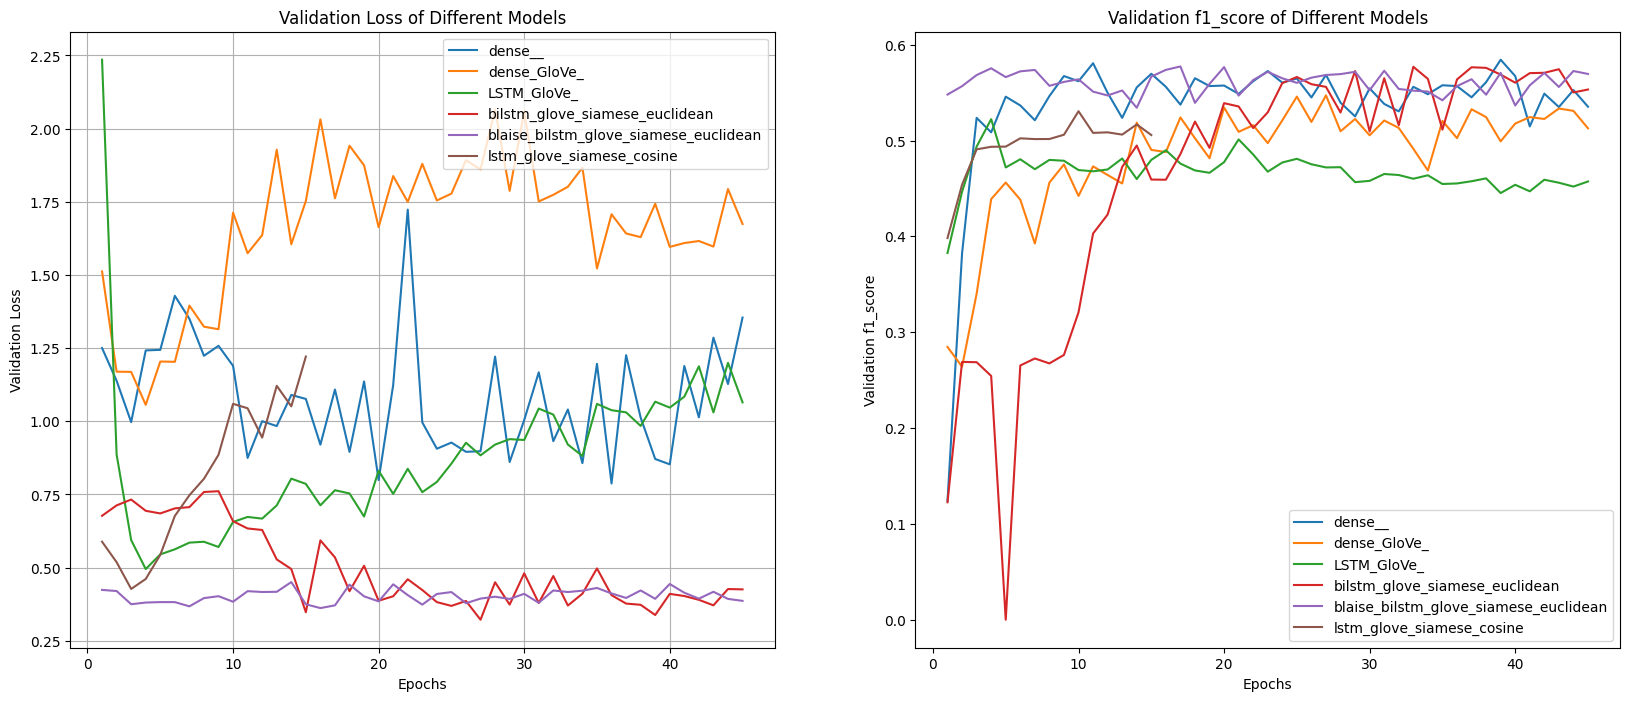

In [72]:
# Initialize a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for model_name, history in model_training.histories.items():
    val_loss = history.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    ax1.plot(epochs, val_loss, label=model_name)

# Add labels and legend
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Validation Loss of Different Models')
ax1.legend()
ax1.grid(True)

for model_name, history in model_training.histories.items():
    val_loss = history.history['val_f1_score_metrics']
    epochs = range(1, len(val_loss) + 1)
    ax2.plot(epochs, val_loss, label=model_name)

# Add labels and legend
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation f1_score')
ax2.set_title('Validation f1_score of Different Models')
ax2.legend()
ax1.grid(True)

# 4.Siamese + BERT embedding

In [73]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [74]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model

In [75]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [124]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model

# Initialize the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize inputs
def preprocess_texts(texts, max_length):
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# Preprocess the texts
max_length = 512  # Adjust based on your requirements

train_doc_tokens, train_doc_masks = preprocess_texts(X_train_doc.tolist(), max_length)
print('Done with training doc')
train_topic_tokens, train_topic_masks = preprocess_texts(X_train_topic.tolist(), max_length)

print('Done with training topic')
val_doc_tokens, val_doc_masks = preprocess_texts(X_val_doc.tolist(), max_length)
print('Done with validate doc')
val_topic_tokens, val_topic_masks = preprocess_texts(X_val_topic.tolist(), max_length)
print('Done with validate topic')
test_doc_tokens, test_doc_masks = preprocess_texts(X_test_doc.tolist(), max_length)
print('Done with testing doc')
test_topic_tokens, test_topic_masks = preprocess_texts(X_test_topic.tolist(), max_length)
print('Done with testing topic')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Done with training doc
Done with training topic
Done with validate doc
Done with validate topic
Done with testing doc
Done with testing topic


In [125]:
# Define input layers for tokenized inputs and attention masks
MAX_SEQUENCE_LENGTH = 512  # or any other fixed length suitable for your data

document_input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='document_input_ids')
document_attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='document_attention_mask')
topic_input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='topic_input_ids')
topic_attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='topic_attention_mask')

# Extract embeddings using BERT model
def get_bert_embeddings(input_ids, attention_mask):
    return bert_model(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

document_embeddings = Lambda(lambda x: get_bert_embeddings(x[0], x[1]))([document_input_ids, document_attention_mask])
topic_embeddings = Lambda(lambda x: get_bert_embeddings(x[0], x[1]))([topic_input_ids, topic_attention_mask])

# Ensure the shape compatibility for the euclidean_distance function
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=-1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# Calculate the Euclidean distance
distance = Lambda(euclidean_distance)([document_embeddings, topic_embeddings])

# Add LSTM layers
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.6))(distance)
lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.4))(lstm1)

# Add a single output layer
out = tf.keras.layers.Dense(1, activation="sigmoid")(lstm2)

# Define the model
model_bidirectional = tf.keras.Model(inputs=[document_input_ids, document_attention_mask, topic_input_ids, topic_attention_mask], outputs=[out])

# Prepare the data for training
train_data = {
    "document_input_ids": train_doc_tokens,
    "document_attention_mask": train_doc_masks,
    "topic_input_ids": train_topic_tokens,
    "topic_attention_mask": train_topic_masks,
}

val_data = {
    "document_input_ids": val_doc_tokens,
    "document_attention_mask": val_doc_masks,
    "topic_input_ids": val_topic_tokens,
    "topic_attention_mask": val_topic_masks,
}

test_data = {
    "document_input_ids": test_doc_tokens,
    "document_attention_mask": test_doc_masks,
    "topic_input_ids": test_topic_tokens,
    "topic_attention_mask": test_topic_masks,
}

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input_ids (InputL  [(None, 512)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 document_attention_mask (I  [(None, 512)]                0         []                            
 nputLayer)                                                                                       
                                                                                                  
 topic_input_ids (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                        

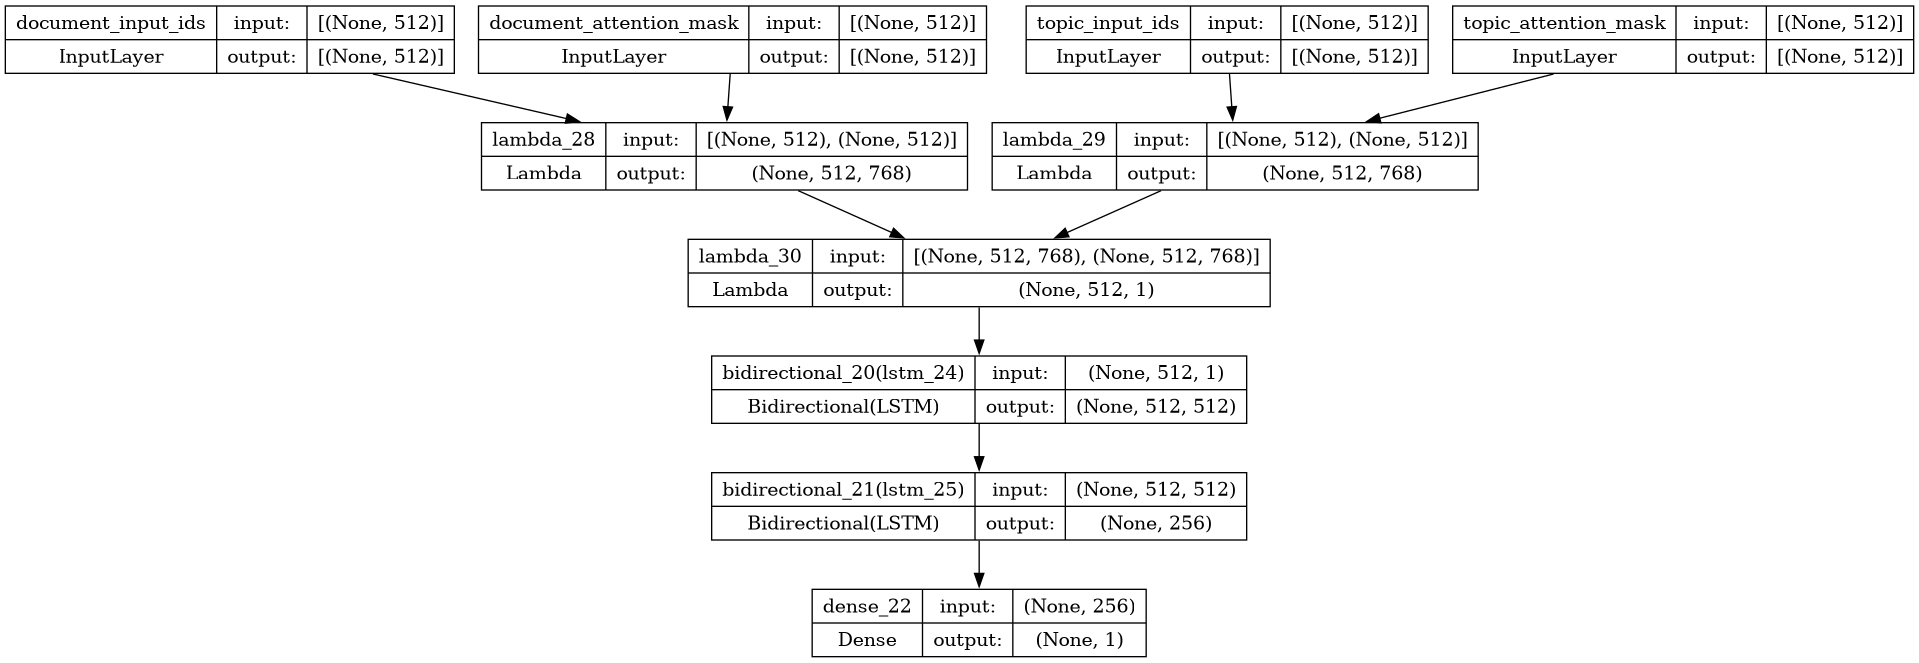

In [126]:
plot_model(model_bidirectional, show_shapes=True)

In [130]:
model_name = 'siamese_bilstm_bert_euclidean'

In [134]:
model_training.compile_model(model_bidirectional, model_name)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 document_input_ids (InputL  [(None, 512)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 document_attention_mask (I  [(None, 512)]                0         []                            
 nputLayer)                                                                                       
                                                                                                  
 topic_input_ids (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                        

In [135]:
model_training.train_model(model_bidirectional, model_name,
                           train_data, y_train,
                           val_data, y_val,
                           test_data, y_test,
                           epochs=5,
                           batch_size=128
                           )

Epoch 1/5
131/131 [==============================] - 1224s 9s/step - loss: 0.6972 - accuracy: 0.5128 - f1_score_metrics: 0.1963 - val_loss: 0.6506 - val_accuracy: 0.8454 - val_f1_score_metrics: 0.0000e+00
Epoch 2/5
131/131 [==============================] - 1107s 8s/step - loss: 0.6948 - accuracy: 0.5385 - f1_score_metrics: 0.1853 - val_loss: 0.8057 - val_accuracy: 0.1546 - val_f1_score_metrics: 0.2673
Epoch 3/5
131/131 [==============================] - 1115s 9s/step - loss: 0.6943 - accuracy: 0.4798 - f1_score_metrics: 0.2174 - val_loss: 0.6863 - val_accuracy: 0.5457 - val_f1_score_metrics: 0.2533
Epoch 4/5
131/131 [==============================] - 1107s 8s/step - loss: 0.6940 - accuracy: 0.5363 - f1_score_metrics: 0.2111 - val_loss: 0.7067 - val_accuracy: 0.1612 - val_f1_score_metrics: 0.2671
Epoch 5/5
31/31 [==============================] - 70s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       821
           1       0

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_589725'
	Captured Tensor = <ResourceHandle(name="tf_bert_model_16/bert/embeddings/word_embeddings/weight/4130", device="/job:localhost/replica:0/task:0/device:GPU:0", container="Anonymous", type="tensorflow::Var", dtype and shapes : "[ DType enum: 1, Shape: [30522,768] ]")>
	Trackable referencing this tensor = <tf.Variable 'tf_bert_model_16/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32>
	Internal Tensor = Tensor("589297:0", shape=(), dtype=resource)

In [136]:
results_dict= model_training.dl_results
# Convert the dictionary to a pandas DataFrame
df_results = pd.DataFrame.from_dict(results_dict, orient='index', columns=['accuracy', 'precision', 'recall', 'f1', 'pred_count'])

# Reset the index to move model names into a column
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'model_name'}, inplace=True)

# Display the DataFrame
print(df_results)

                              model_name  accuracy  precision    recall  \
0                                dense__  0.859487   0.562963  0.493506   
1                           dense_GloVe_  0.820513   0.445026  0.551948   
2                            LSTM_GloVe_  0.798974   0.383333  0.448052   
3         bilstm_glove_siamese_euclidean  0.798974   0.423358  0.753247   
4  blaise_bilstm_glove_siamese_euclidean  0.832821   0.479070  0.668831   
5              lstm_glove_siamese_cosine  0.803077   0.411215  0.571429   
6          siamese_bilstm_bert_euclidean  0.157949   0.157949  1.000000   

         f1  pred_count  
0  0.525952         135  
1  0.492754         191  
2  0.413174         180  
3  0.542056         274  
4  0.558266         215  
5  0.478261         214  
6  0.272808         975  


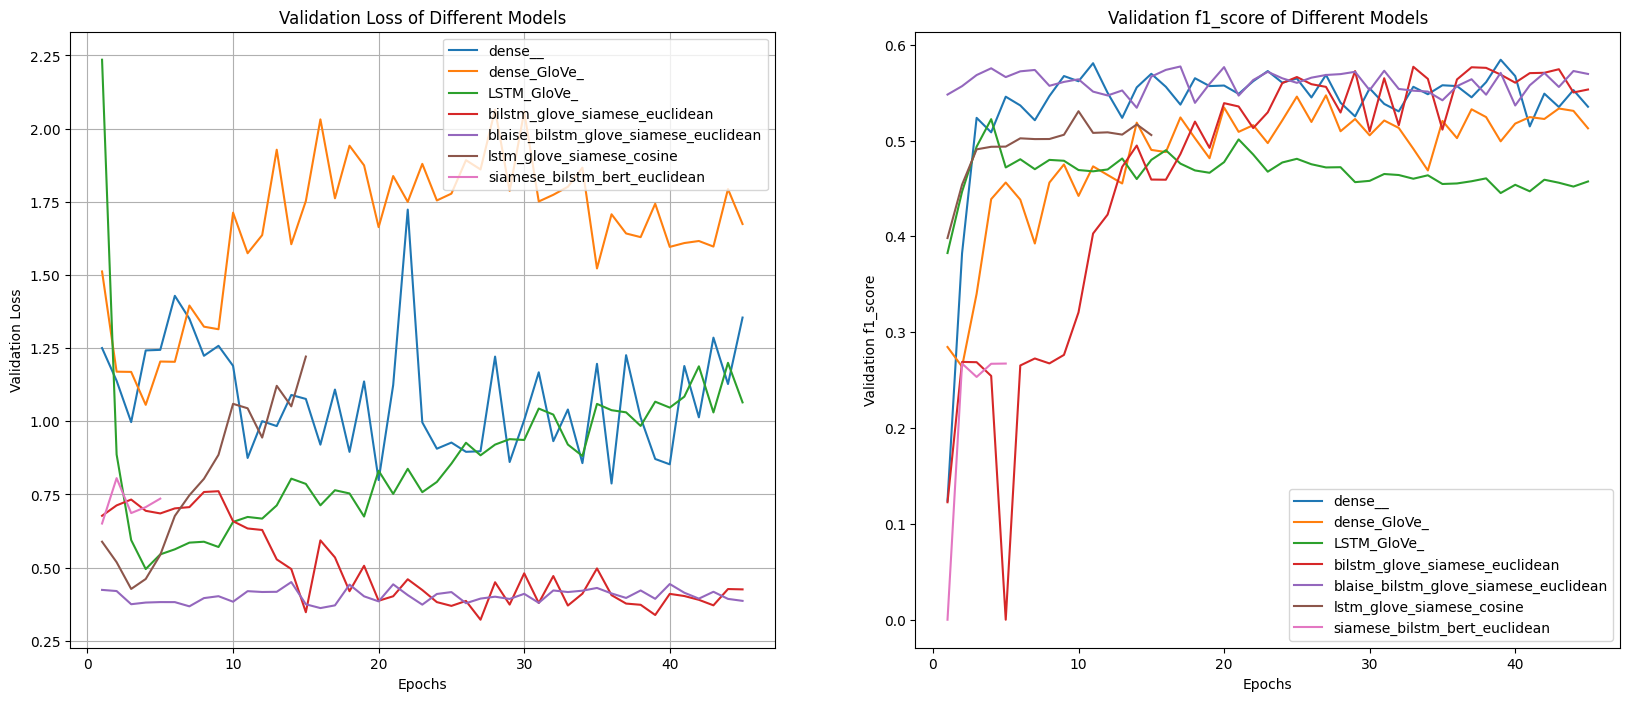

In [137]:
# Initialize a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for model_name, history in model_training.histories.items():
    val_loss = history.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    ax1.plot(epochs, val_loss, label=model_name)

# Add labels and legend
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Validation Loss of Different Models')
ax1.legend()
ax1.grid(True)

for model_name, history in model_training.histories.items():
    val_loss = history.history['val_f1_score_metrics']
    epochs = range(1, len(val_loss) + 1)
    ax2.plot(epochs, val_loss, label=model_name)

# Add labels and legend
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation f1_score')
ax2.set_title('Validation f1_score of Different Models')
ax2.legend()
ax1.grid(True)

# 5.Loading pretrained models for reusability

In [45]:
# @title
from tensorflow.keras.models import load_model

# Function to load and make predictions for a single model
CNN_glove_model = load_model('/kaggle/input/trained-model/CNN_glove',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
Dense_glove_model = load_model('/kaggle/input/trained-model/Dense_GloVe',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
Dense_NN_model = load_model('/kaggle/input/trained-model/Dense_NN',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
bilstm_glove_model = load_model('/kaggle/input/trained-model/bilstm_GloVe',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
bilstm_euclid_glove_model = load_model('/kaggle/input/trained-model/bilstm_euclid_glove',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
lstm_glove_model = load_model('/kaggle/input/trained-model/lstm_GloVe',
                       custom_objects={'f1_score_metrics': f1_score_metrics})
siamese_glove_cosine_model = load_model('/kaggle/input/trained-model/siamese_glove_cosine',
                       custom_objects={'auroc': auroc})
test_pred = CNN_glove_model.predict([X_test_doc, X_test_topic]).flatten()
dl_metrics(test_pred,y_test, 'CNN_glove')
test_pred = Dense_glove_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'Dense_glove')
test_pred = Dense_NN_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'Dense_NN')
test_pred = bilstm_glove_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'bilstm_glove')
test_pred = lstm_glove_model.predict(X_test_concat).flatten()
dl_metrics(test_pred,y_test, 'lstm_glove')
test_pred = siamese_glove_cosine_model.predict([X_test_doc, X_test_topic]).flatten()
dl_metrics(test_pred,y_test, 'siamese_glove_cosine')
test_pred = bilstm_euclid_glove_model.predict([X_test_doc, X_test_topic]).flatten()
dl_metrics(test_pred,y_test, 'bilstm_euclid_glove')

# Convert the dictionary into a pandas DataFrame
dl_results_df = pd.DataFrame.from_dict(dl_results,
                                    orient='index',
                                    columns=['accuracy','precision','recall','f1_core','count_predictions'])
# Display the results as a table
print("Model Performance Comparison:")
dl_results_df

NameError: name 'f1_score_metrics' is not defined

In [ ]:
# @title
import os
import pickle
import matplotlib.pyplot as plt

# Directory containing pickle files
directory = '/kaggle/input/trained-model'

# List of pickle files
pickle_files = [
    "cnn_history.pkl",
    "glove_bilstm_euclid_history.pkl",
    "simese_glove_cosine_history.pkl"
]

# Plot validation loss
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
for file in pickle_files:
    filepath = os.path.join(directory, file)
    with open(filepath, 'rb') as f:
        history = pickle.load(f)

    # Extract validation loss values
    val_loss = history['val_loss']

    # Plot validation loss
    plt.plot(val_loss, label=file)

# Set labels and legend
plt.title('Validation Loss Value Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training loss
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
for file in pickle_files:
    filepath = os.path.join(directory, file)
    with open(filepath, 'rb') as f:
        history = pickle.load(f)

    # Extract training loss values
    loss = history['loss']

    # Plot training loss
    plt.plot(loss, label=file)

# Set labels and legend
plt.title('Training Loss Value Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# @title
# Compute precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, test_pred)

# Initialize lists to store F1 scores
f1_scores = []

# Compute F1 scores for each threshold
for i in range(len(thresholds)):
    # Compute F1 score
    f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-5)  # Adding a small value to avoid division by zero
    f1_scores.append(f1)

# Plot F1 scores
plt.plot(thresholds, f1_scores, marker='.')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()
# Initialize variables to store optimal values
optimal_threshold = None
optimal_f1_score = -1

# Iterate over each threshold and calculate F1 score
for i in range(len(thresholds)):
    threshold = thresholds[i]
    y_pred = (test_pred >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > optimal_f1_score:
        optimal_f1_score = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Optimal F1 Score:", optimal_f1_score)

#References

"Developing and Evaluating Siamese Neural Networks: A Comprehensive Guide to Architecture" by Dr. Isaac Faber. Available at: Medium

GloVe: Global Vectors for Word Representation by Jeffrey Pennington, Richard Socher, and Christopher D. Manning. Available at: Stanford NLP

"Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks" by Nils Reimers and Iryna Gurevych. Available at: arXiv

"Siamese Neural Networks for One-shot Image Recognition" by Gregory Koch, Richard Zemel, and Ruslan Salakhutdinov. Available at: SpringerLink

"Bert-based Siamese Network for Semantic Similarity" by Z Yan, H Wu, X Li, and Z Jiao. Available at: IOPscience

GitHub repository by Rafal Jan Wojcik comparing SentenceBERT vs. Siamese LSTM. Available at: GitHub

GitHub repository for the Sentence Transformers library by UKPLab. Available at: GitHub